# MNIST

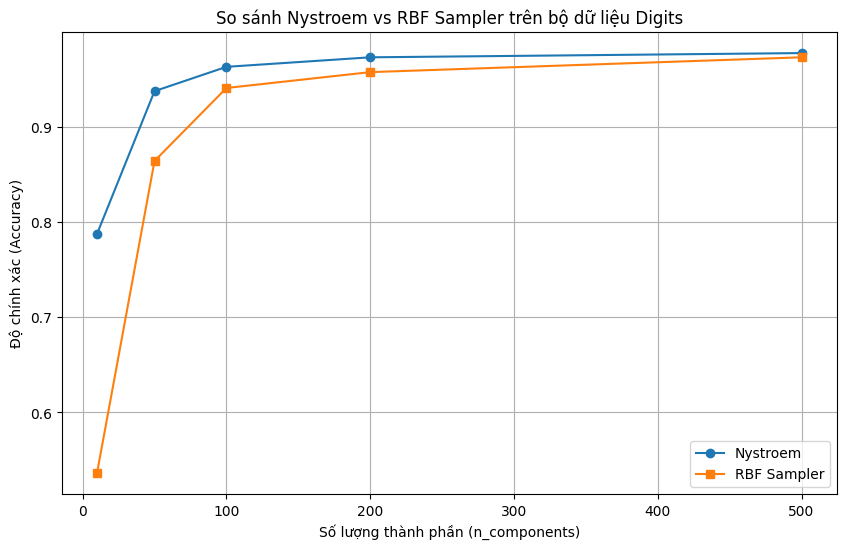

In [1]:
import matplotlib.pyplot as plt
import time
from sklearn import datasets, svm, pipeline
from sklearn.kernel_approximation import RBFSampler, Nystroem
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split

# 1. Chuẩn bị dữ liệu
digits = datasets.load_digits()
n_samples = len(digits.data)
data = digits.data / 16.0 # Chuẩn hóa dữ liệu
X_train, X_test, y_train, y_test = train_test_split(data, digits.target, test_size=0.5)

# 2. Các giá trị n_components để thử nghiệm
n_components_values = [10, 50, 100, 200, 500]
nystroem_scores = []
rbf_sampler_scores = []

# 3. Chạy thí nghiệm
for n in n_components_values:
    # Thử với Nystroem
    nystroem_model = pipeline.Pipeline([
        ("feature_map", Nystroem(gamma=0.2, n_components=n)),
        ("svm", SGDClassifier(max_iter=100))
    ])
    nystroem_model.fit(X_train, y_train)
    nystroem_scores.append(nystroem_model.score(X_test, y_test))

    # Thử với RBF Sampler
    rbf_model = pipeline.Pipeline([
        ("feature_map", RBFSampler(gamma=0.2, n_components=n)),
        ("svm", SGDClassifier(max_iter=100))
    ])
    rbf_model.fit(X_train, y_train)
    rbf_sampler_scores.append(rbf_model.score(X_test, y_test))

# 4. Vẽ biểu đồ so sánh
plt.figure(figsize=(10, 6))
plt.plot(n_components_values, nystroem_scores, 'o-', label='Nystroem')
plt.plot(n_components_values, rbf_sampler_scores, 's-', label='RBF Sampler')
plt.xlabel('Số lượng thành phần (n_components)')
plt.ylabel('Độ chính xác (Accuracy)')
plt.title('So sánh Nystroem vs RBF Sampler trên bộ dữ liệu Digits')
plt.legend()
plt.grid(True)
plt.show()

# Covertype & 20News

--- Vectorizing Text Data...
  Testing m=100...
  Testing m=500...
  Testing m=1000...
  Testing m=2000...


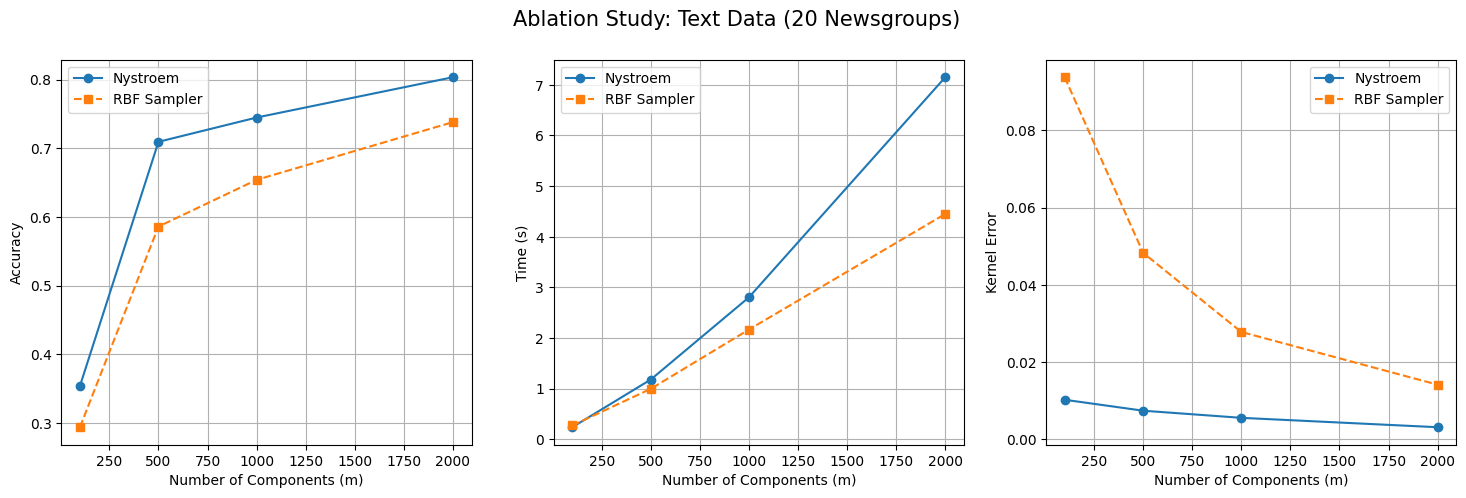

--- Loading Tabular Data Offline (covtype.data.gz, subset 20000)...
  Testing m=100...
  Testing m=500...
  Testing m=1000...
  Testing m=2000...


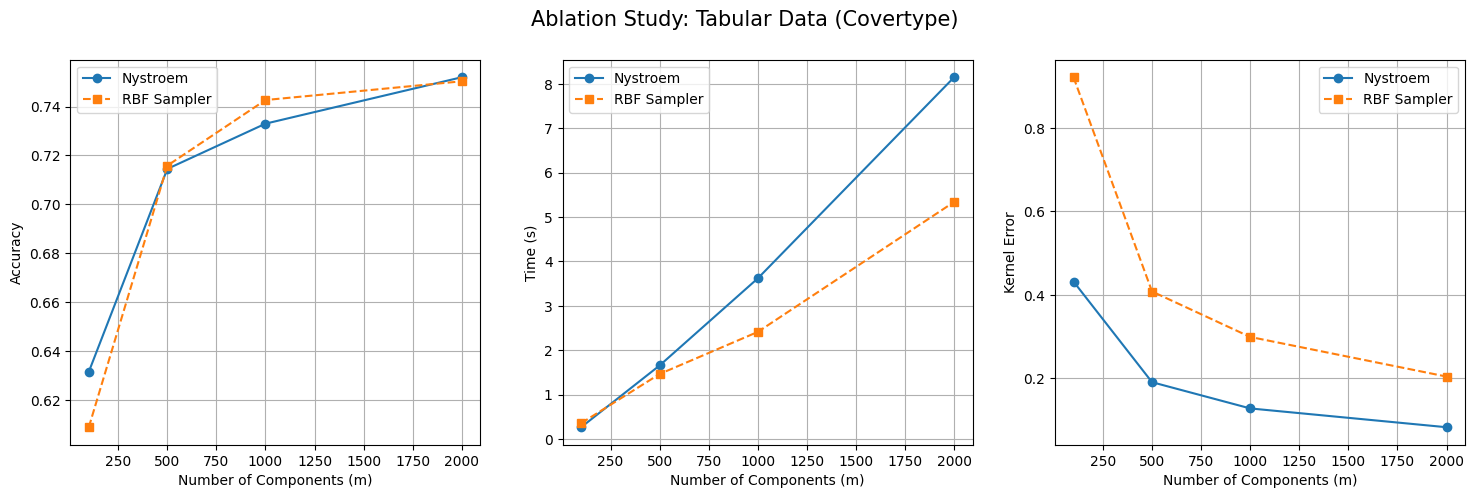

--- Loading Adult Offline (adult.data, adult.test)...
  Testing m=100...
  Testing m=500...
  Testing m=1000...
  Testing m=2000...


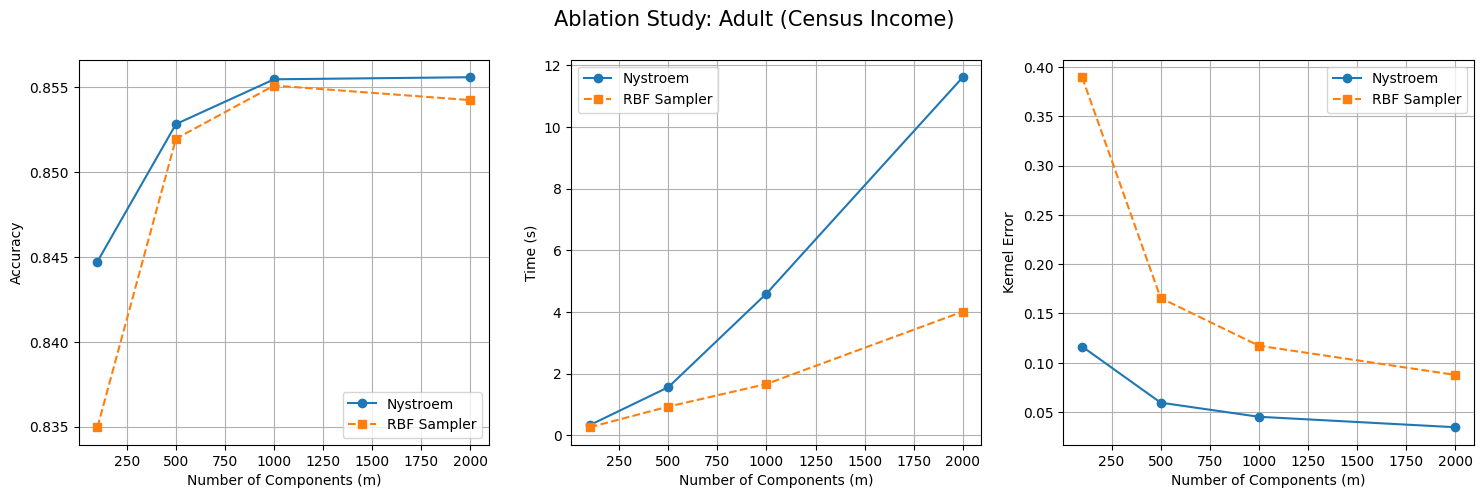

In [2]:
import os
import tarfile
import gzip
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_covtype, load_files
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.kernel_approximation import Nystroem, RBFSampler
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import rbf_kernel

# ==========================================
# 1. HÀM GIẢI NÉN VÀ LOAD DỮ LIỆU TEXT THỦ CÔNG
# ==========================================
def load_custom_20news(file_path, n_samples=5000):
    data_home = "./20news_data"
    extract_path = os.path.join(data_home, "20news-bydate-train")
    
    # Giải nén nếu chưa tồn tại
    if not os.path.exists(extract_path):
        print(f"--- Extracting {file_path}...")
        with tarfile.open(file_path, "r:gz") as tar:
            tar.extractall(path=data_home)
    
    # Load dữ liệu từ thư mục đã giải nén bằng load_files
    # Chỉ lấy một vài category để tăng tốc độ và tính đa dạng
    print("--- Vectorizing Text Data...")
    container = load_files(container_path=extract_path, encoding='latin1')
    X_raw, y = container.data[:n_samples], container.target[:n_samples]
    
    # Chuyển đổi sang TF-IDF
    tfidf = TfidfVectorizer(max_features=5000, stop_words='english')
    X = tfidf.fit_transform(X_raw)
    X = Normalizer().fit_transform(X) # Quan trọng cho Kernel Approximation
    return train_test_split(X, y, test_size=0.3, random_state=42)

# ==========================================
# 2. HÀM LOAD DỮ LIỆU TABULAR (COVERTYPE)
# ==========================================
def load_tabular_data_offline(file_path="covtype.data.gz", n_samples=20000):
    print(f"--- Loading Tabular Data Offline ({file_path}, subset {n_samples})...")
    
    try:
        # Đọc dữ liệu trực tiếp từ file .gz bằng pandas
        # Covertype không có header, cột cuối cùng (54) là target
        with gzip.open(file_path, 'rb') as f:
            df = pd.read_csv(f, header=None)
        
        # Lấy subset để benchmark nhanh
        df_subset = df.sample(n=min(n_samples, len(df)), random_state=42)
        
        X = df_subset.iloc[:, :-1].values # Tất cả các cột trừ cột cuối
        y = df_subset.iloc[:, -1].values  # Cột cuối cùng là nhãn loại rừng
        
        # Chuẩn hóa dữ liệu (Rất quan trọng cho Nystroem/RBF)
        X = StandardScaler().fit_transform(X)
        
        return train_test_split(X, y, test_size=0.3, random_state=42)
    
    except FileNotFoundError:
        print(f"Lỗi: Không tìm thấy file '{file_path}' trong thư mục.")
        return None, None, None, None
    
def load_adult_data_offline(train_path="adult.data", test_path="adult.test"):
    print(f"--- Loading Adult Offline ({train_path}, {test_path})...")

    import pandas as pd
    from sklearn.compose import ColumnTransformer
    from sklearn.pipeline import Pipeline
    from sklearn.preprocessing import OneHotEncoder, StandardScaler
    from sklearn.impute import SimpleImputer

    # fallback nếu bạn chạy trên môi trường có /mnt/data
    if not os.path.exists(train_path) and os.path.exists(os.path.join("/mnt/data", train_path)):
        train_path = os.path.join("/mnt/data", train_path)
    if not os.path.exists(test_path) and os.path.exists(os.path.join("/mnt/data", test_path)):
        test_path = os.path.join("/mnt/data", test_path)

    if not os.path.exists(train_path):
        raise FileNotFoundError(train_path)
    if not os.path.exists(test_path):
        raise FileNotFoundError(test_path)

    ADULT_COLUMNS = [
        "age", "workclass", "fnlwgt", "education", "education_num",
        "marital_status", "occupation", "relationship", "race", "sex",
        "capital_gain", "capital_loss", "hours_per_week", "native_country",
        "income",
    ]
    NUM_COLS = ["age", "fnlwgt", "education_num", "capital_gain", "capital_loss", "hours_per_week"]
    CAT_COLS = ["workclass", "education", "marital_status", "occupation",
                "relationship", "race", "sex", "native_country"]

    # đọc train/test
    train_df = pd.read_csv(
        train_path, header=None, names=ADULT_COLUMNS,
        sep=",", na_values="?", skipinitialspace=True, engine="python"
    )
    test_df = pd.read_csv(
        test_path, header=None, names=ADULT_COLUMNS,
        sep=",", na_values="?", skipinitialspace=True, engine="python",
        skiprows=1  # adult.test có 1 dòng header kiểu '|1x3 Cross validator'
    )

    # clean label (test hay có dấu '.')
    for df in (train_df, test_df):
        df["income"] = df["income"].astype(str).str.strip().str.replace(".", "", regex=False)

    X_train_raw = train_df.drop(columns=["income"])
    y_train = (train_df["income"] == ">50K").astype(int).to_numpy()

    X_test_raw = test_df.drop(columns=["income"])
    y_test = (test_df["income"] == ">50K").astype(int).to_numpy()

    # preprocess: median+scale cho numeric, most_frequent+onehot cho categorical
    num_pipe = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
    ])
    cat_pipe = Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore")),
    ])
    preprocess = ColumnTransformer(
        transformers=[
            ("num", num_pipe, NUM_COLS),
            ("cat", cat_pipe, CAT_COLS),
        ],
        remainder="drop",
        sparse_threshold=0.3
    )

    X_train = preprocess.fit_transform(X_train_raw)
    X_test = preprocess.transform(X_test_raw)

    return X_train, X_test, y_train, y_test

# ==========================================
# 3. HÀM TÍNH KERNEL ERROR & BENCHMARK
# ==========================================
def compute_kernel_error(X, transformer, n_subset=500):
    # Lấy subset nhỏ để tính ma trận Gram thật (vì n^2 rất lớn)
    X_sub = X[:n_subset].toarray() if hasattr(X, "toarray") else X[:n_subset]
    K_true = rbf_kernel(X_sub, gamma=0.1) # Giả sử gamma cố định để so sánh
    
    X_features = transformer.transform(X_sub)
    K_approx = np.dot(X_features, X_features.T)
    
    error = np.linalg.norm(K_true - K_approx) / np.linalg.norm(K_true)
    return error

def run_benchmark(X_train, X_test, y_train, y_test, components_list):
    results = {'nystroem': {'acc': [], 'time': [], 'err': []}, 
               'rbf': {'acc': [], 'time': [], 'err': []}}

    for m in components_list:
        print(f"  Testing m={m}...")
        for name, transformer in [
            ('nystroem', Nystroem(kernel='rbf', n_components=m, gamma=0.1, random_state=42)),
            ('rbf', RBFSampler(n_components=m, gamma=0.1, random_state=42))
        ]:
            start = time.time()
            X_tr_mapped = transformer.fit_transform(X_train)
            X_te_mapped = transformer.transform(X_test)
            
            clf = SGDClassifier(max_iter=1000, tol=1e-3).fit(X_tr_mapped, y_train)
            
            results[name]['time'].append(time.time() - start)
            results[name]['acc'].append(accuracy_score(y_test, clf.predict(X_te_mapped)))
            results[name]['err'].append(compute_kernel_error(X_train, transformer))
            
    return results

# ==========================================
# 4. VẼ BIỂU ĐỒ ABLATION STUDY
# ==========================================
def plot_ablation(components, results, title):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))
    fig.suptitle(f'Ablation Study: {title}', fontsize=15)

    for metric, ax, label in [('acc', ax1, 'Accuracy'), ('time', ax2, 'Time (s)'), ('err', ax3, 'Kernel Error')]:
        ax.plot(components, results['nystroem'][metric], 'o-', label='Nystroem')
        ax.plot(components, results['rbf'][metric], 's--', label='RBF Sampler')
        ax.set_xlabel('Number of Components (m)')
        ax.set_ylabel(label)
        ax.legend()
        ax.grid(True)
    plt.show()

# ==========================================
# 5. THỰC THI CHÍNH
# ==========================================
if __name__ == "__main__":
    m_values = [100, 500, 1000, 2000]
    
    # Chạy cho Dữ liệu Text
    # Đảm bảo file '20news-bydate.tar.gz' nằm cùng thư mục này
    try:
        X_train_t, X_test_t, y_train_t, y_test_t = load_custom_20news("20news-bydate.tar.gz")
        res_text = run_benchmark(X_train_t, X_test_t, y_train_t, y_test_t, m_values)
        plot_ablation(m_values, res_text, "Text Data (20 Newsgroups)")
    except FileNotFoundError:
        print("Lỗi: Không tìm thấy file '20news-bydate.tar.gz'. Vui lòng để file vào cùng thư mục code.")

    # Chạy cho Dữ liệu Tabular
    X_train_tab, X_test_tab, y_train_tab, y_test_tab = load_tabular_data_offline("covtype.data.gz")
    res_tab = run_benchmark(X_train_tab, X_test_tab, y_train_tab, y_test_tab, m_values)
    plot_ablation(m_values, res_tab, "Tabular Data (Covertype)")
    
        # Chạy cho Dữ liệu Adult
    try:
        X_train_a, X_test_a, y_train_a, y_test_a = load_adult_data_offline("adult.data", "adult.test")
        res_adult = run_benchmark(X_train_a, X_test_a, y_train_a, y_test_a, m_values)
        plot_ablation(m_values, res_adult, "Adult (Census Income)")
    except FileNotFoundError:
        print("Lỗi: Không tìm thấy 'adult.data' / 'adult.test'. Vui lòng để file vào cùng thư mục code.")


In [4]:
import pandas as pd

def results_dict_to_df(dataset_name, components_list, results_dict, gamma=0.1):
    rows = []
    for method in ["nystroem", "rbf"]:
        for m, acc, t, err in zip(
            components_list,
            results_dict[method]["acc"],
            results_dict[method]["time"],
            results_dict[method]["err"],
        ):
            rows.append({
                "dataset": dataset_name,
                "method": method,
                "gamma": gamma,
                "m": m,
                "acc": acc,
                "time_s": t,
                "kernel_err": err,
            })
    return pd.DataFrame(rows)

# --- gom kết quả 3 dataset ---
dfs = []
dfs.append(results_dict_to_df("20news", m_values, res_text, gamma=0.1))
dfs.append(results_dict_to_df("covtype", m_values, res_tab,  gamma=0.1))

# nếu bạn đã thêm Adult theo patch trước đó
dfs.append(results_dict_to_df("adult",  m_values, res_adult, gamma=0.1))

df_all = pd.concat(dfs, ignore_index=True)

out_path = "kernel_approx_results_3datasets.csv"
df_all.to_csv(out_path, index=False)
print(f"Saved CSV to: {out_path}")
display(df_all)


✅ Saved CSV to: kernel_approx_results_3datasets.csv


,dataset,method,gamma,m,acc,time_s,kernel_err
0,20news,nystroem,0.1,100,0.354000,0.238400,0.010267
1,20news,nystroem,0.1,500,0.709333,1.180468,0.007435
2,20news,nystroem,0.1,1000,0.744667,2.804386,0.005588
3,20news,nystroem,0.1,2000,0.803333,7.150240,0.003157
4,20news,rbf,0.1,100,0.294000,0.272723,0.093769
5,20news,rbf,0.1,500,0.586000,0.996951,0.048298
6,20news,rbf,0.1,1000,0.654000,2.167513,0.027820
7,20news,rbf,0.1,2000,0.738000,4.450464,0.014164
8,covtype,nystroem,0.1,100,0.631500,0.264598,0.431870
9,covtype,nystroem,0.1,500,0.714500,1.657148,0.190354



--- Running Gamma Ablation (Fixed m=1000) ---
  Testing Gamma = 0.001...
  Testing Gamma = 0.01...
  Testing Gamma = 0.1...
  Testing Gamma = 1.0...
  Testing Gamma = 10.0...


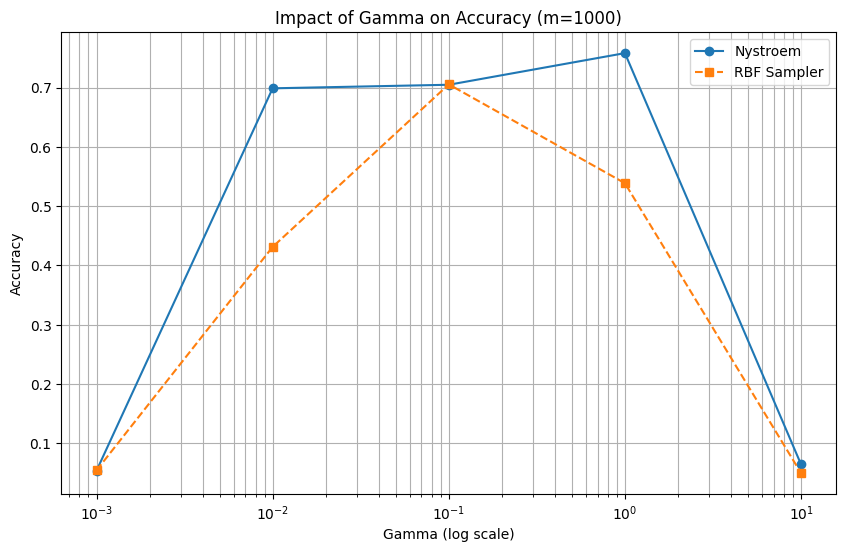

In [3]:
def run_gamma_ablation(X_train, X_test, y_train, y_test, gamma_list, m_fixed=1000):
    print(f"\n--- Running Gamma Ablation (Fixed m={m_fixed}) ---")
    results = {'nystroem': [], 'rbf': []}

    for g in gamma_list:
        print(f"  Testing Gamma = {g}...")
        for name, transformer in [
            ('nystroem', Nystroem(kernel='rbf', n_components=m_fixed, gamma=g, random_state=42)),
            ('rbf', RBFSampler(n_components=m_fixed, gamma=g, random_state=42))
        ]:
            # Biến đổi đặc trưng
            X_tr_mapped = transformer.fit_transform(X_train)
            X_te_mapped = transformer.transform(X_test)
            
            # Huấn luyện nhanh với SGD
            clf = SGDClassifier(max_iter=1000, tol=1e-3).fit(X_tr_mapped, y_train)
            acc = accuracy_score(y_test, clf.predict(X_te_mapped))
            results[name].append(acc)
            
    # Vẽ biểu đồ Gamma Ablation
    plt.figure(figsize=(10, 6))
    plt.plot(gamma_list, results['nystroem'], 'o-', label='Nystroem')
    plt.plot(gamma_list, results['rbf'], 's--', label='RBF Sampler')
    plt.xscale('log') # Dùng thang đo log vì gamma thường trải dài (0.001 đến 10)
    plt.title(f'Impact of Gamma on Accuracy (m={m_fixed})')
    plt.xlabel('Gamma (log scale)')
    plt.ylabel('Accuracy')
    plt.grid(True, which="both", ls="-")
    plt.legend()
    plt.show()


gamma_values = [0.001, 0.01, 0.1, 1.0, 10.0]
run_gamma_ablation(X_train_t, X_test_t, y_train_t, y_test_t, gamma_values)